### 2d Experiment using RCPS \& Proto-RCPS
- Create multivariate gaussian mixture:

$$
\mathcal{D} = 

\frac{1}{3}
\mathcal{N}([0,0]^T, \begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix}) 
+

\frac{1}{3}
\mathcal{N}([3,3]^T, \begin{bmatrix}
0.5 & 0.2 \\
0.2 & 0.5 
\end{bmatrix}) 
+

\frac{1}{3}
\mathcal{N}([-3,-4]^T, \begin{bmatrix}
0.7 & -0.2 \\
-0.2 & 0.7 
\end{bmatrix}) 
$$

- $30.000$ Samples
- **RCPS**: $50 \times 50 = 2500$ bin centers. $X \in \{-7,7\}$ , $Y \in \{-7, 7\}$
- **RCPS-Proto**: $50 \times 50 = 2500$ prototypes initialized at $X \in \{-7,7\}$ , $Y \in \{-7, 7\}$
#
- Issues-1: Predicted output probabilities do not correspond to correct probabilities. Have to adjust according to the region of each prototype.
- Issues-2: Many Unused Prototypes exist.
 
- Edited by Halil for calculating conformal prediction and covarage 
- Tried new losses for to improve model 

- Edited by Batu for kd-tree approach


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

from scipy.stats import multivariate_normal
from scipy.spatial import Voronoi, voronoi_plot_2d

import torch
import torch.nn as nn
import torch.nn.functional as F

from time import sleep
from IPython.display import clear_output


/opt/anaconda3/envs/batu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


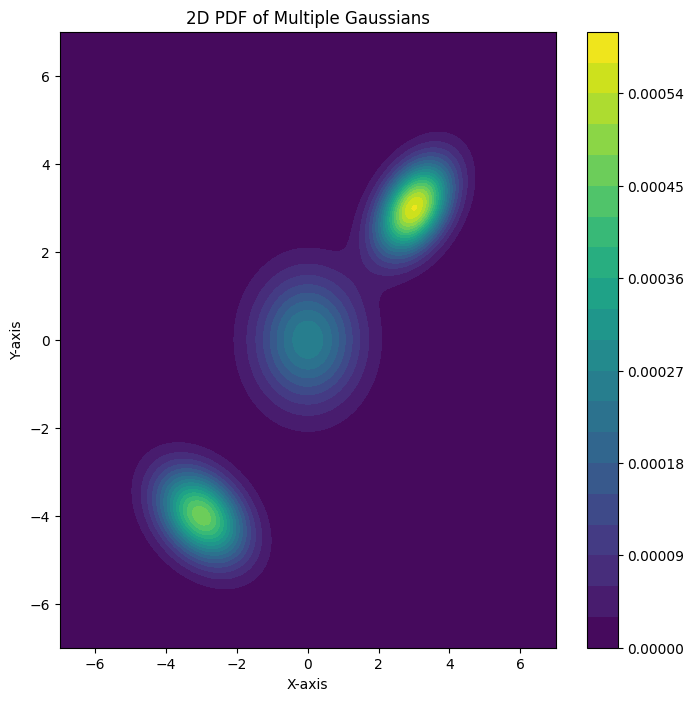

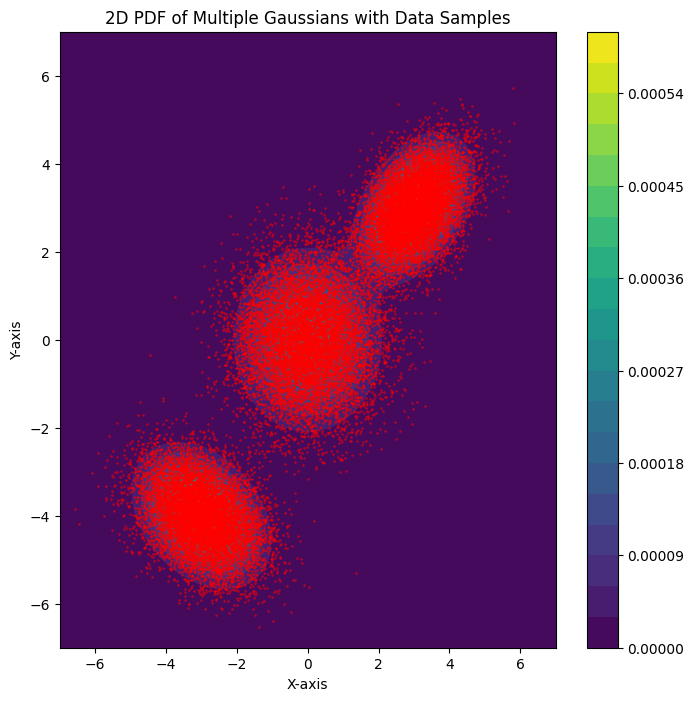

In [2]:
np.random.seed(0)

# Centers of the Gaussians
means = [(0, 0), 
         (3, 3), 
         (-3, -4)]  
# Covariance matrices
covariances = [ [[1, 0], 
                 [0, 1]], 
               [[0.5, 0.2], 
                [0.2, 0.5]], 
               [[0.7, -0.2], 
                [-0.2, 0.5]] ] 
# Number of data samples
sizes = [10000,
         10000,
         10000]

# Grid space (-7,7)x(-7,7)
x = np.linspace(-7, 7, 200)
y = np.linspace(-7, 7, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Create the combined Gaussian distribution
Z = np.zeros(X.shape)
data_samples = []
for mean, cov, size in zip(means, covariances, sizes):
    # Generate data samples from the Gaussian
    rv = np.random.multivariate_normal(mean, cov, size=size)
    data_samples.append(rv)
    
    # Add the Gaussian PDF contribution to the grid
    rv_pdf = multivariate_normal(mean, cov).pdf(pos)
    # Z += np.exp(-0.5 * (np.sum(np.dot(pos - mean, np.linalg.inv(cov)) * (pos - mean), axis=2))) * np.linalg.det(cov)**(-1/2) * size
    Z += rv_pdf * size  # Weight by the number of samples for each distribution

data_samples = np.vstack(data_samples)

# Normalize the combined distribution
Z /= np.sum(Z)

# Plot the 2D PDF
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Plot the 2D PDF with data samples
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.scatter(data_samples[:,0], data_samples[:,1], c='r', s=1, marker='x', alpha=0.5)
plt.title('2D PDF of Multiple Gaussians with Data Samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


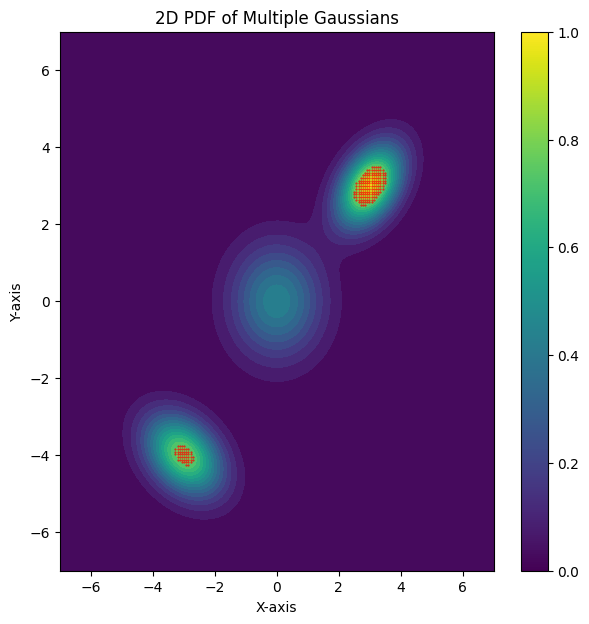

In [3]:
# Flatten the Z array and sort it in descending order
Z_flat = Z.flatten()
sorted_indices = np.argsort(Z_flat)[::-1]
sorted_Z = Z_flat[sorted_indices]

# Calculate the cumulative sum and find the threshold index
cumulative_sum = np.cumsum(sorted_Z)
threshold_index = np.where(cumulative_sum >= 0.1)[0][0]

# Get the x, y coordinates for the corresponding indices
top_indices = sorted_indices[:threshold_index+1]
top_x = X.flatten()[top_indices]
top_y = Y.flatten()[top_indices]

plt.figure(figsize=(7, 7))
# Plot the 2D PDF
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.scatter(top_x, top_y, c='red',s=0.2)
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [4]:
top_x.shape

(204,)

In [5]:
((X[0,1] - X[0,0]) ** 2) * 204

1.0096714729425922

In [6]:
GLOBAL_BIN_COUNT = 50

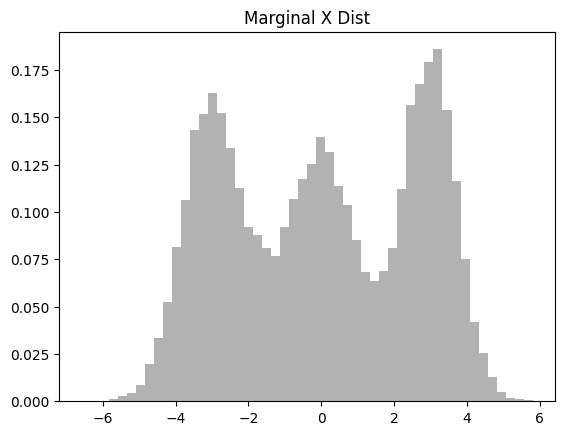

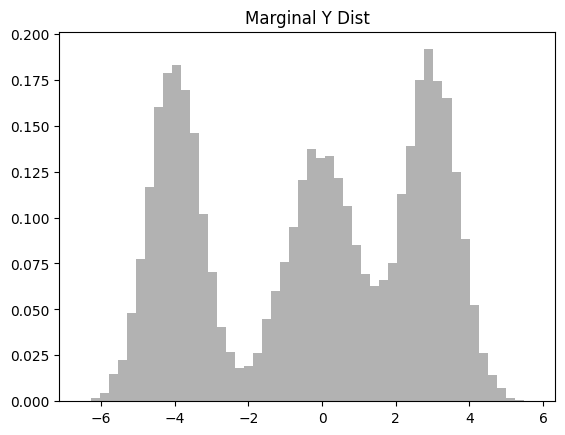

In [7]:
# Get X Centers
plt.figure()
plt.title("Marginal X Dist")
X_bin_count = GLOBAL_BIN_COUNT
X_hist = plt.hist(data_samples[:,0], bins=X_bin_count, density=True, alpha=0.6, color='gray', label='Data')
X_digital_labels = np.fmin(np.digitize(data_samples[:,0], X_hist[1]), X_bin_count)

# Get Y Centers
plt.figure()
plt.title("Marginal Y Dist")
Y_bin_count = GLOBAL_BIN_COUNT
Y_hist = plt.hist(data_samples[:,1], bins=Y_bin_count, density=True, alpha=0.6, color='gray', label='Data')
Y_digital_labels = np.fmin(np.digitize(data_samples[:,1], Y_hist[1]), Y_bin_count)

digital_labels = ((X_digital_labels-1) + (Y_digital_labels-1) * Y_bin_count)

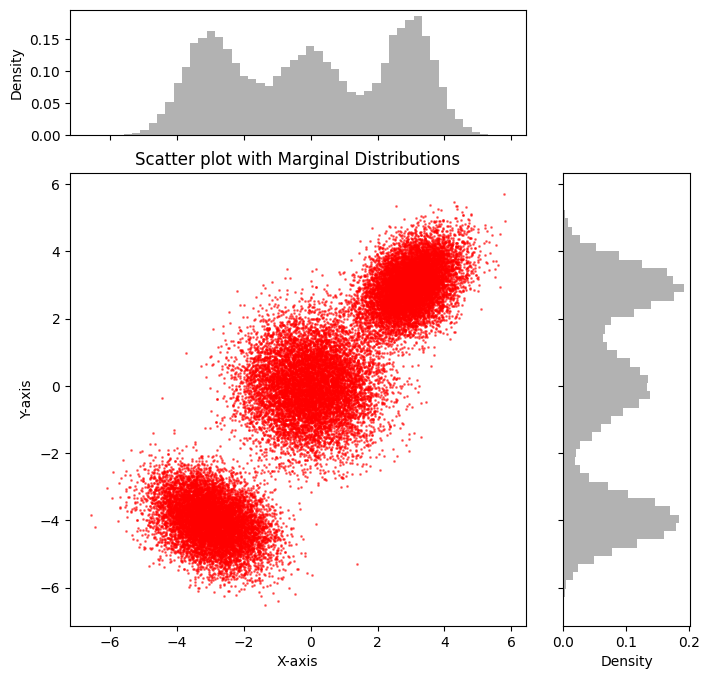

In [8]:
# Create a figure with a main plot area and two marginal histograms
from matplotlib import gridspec

# Set up the figure with specified size and gridspec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4, hspace=0.3, wspace=0.3)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_main.scatter(data_samples[:, 0], data_samples[:, 1], c='r', s=1, alpha=0.5)
ax_main.set_xlabel('X-axis')
ax_main.set_ylabel('Y-axis')
ax_main.set_title('Scatter plot with Marginal Distributions')

# Marginal histogram for X
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(data_samples[:, 0], bins=X_bin_count, density=True, alpha=0.6, color='gray')
ax_histx.set_ylabel('Density')
ax_histx.tick_params(axis='x', labelbottom=False)  # Hide x labels for top histogram

# Marginal histogram for Y
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(data_samples[:, 1], bins=Y_bin_count, density=True, alpha=0.6, color='gray', orientation='horizontal')
ax_histy.set_xlabel('Density')
ax_histy.tick_params(axis='y', labelleft=False)  # Hide y labels for right histogram

plt.show()


In [9]:
import torch

def get_cuda_summary(memory=False):
    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('CUDA is not available')

# Check CUDA summary
get_cuda_summary()

# Set up device
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        device = torch.device('cuda:1')  # Prefer cuda:1 if available
    else:
        device = torch.device('cuda:0')  # Fallback to cuda:0 if only one CUDA device is available
else:
    device = torch.device('cpu')  # Fallback to CPU if CUDA is not available

torch.cuda.set_device(device) if torch.cuda.is_available() else None

print(f"Using device: {device}")


CUDA device =  NVIDIA TITAN RTX
Available number of devices =  1
Device numbers              =  [0]
Current device              =  0
Using device: cuda:0


In [10]:
class UnconditionalClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=GLOBAL_BIN_COUNT*GLOBAL_BIN_COUNT):
        super(UnconditionalClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.no_of_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [11]:
digital_labels.shape

(30000,)

In [12]:
Y =torch.from_numpy((digital_labels).reshape(-1)).to(device)
X = torch.zeros_like(Y).reshape(-1,1).float().to(device)

# split the data
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=1)
test_x, cal_x, test_y, cal_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1)



model = UnconditionalClassifier().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

In [13]:
losses = []
torch.manual_seed(0)
for step in range(500):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x)
    loss = criterion(logits, train_y)
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 100 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=7.824
epoch 100 loss=6.25


epoch 200 loss=6.24
epoch 300 loss=6.238
epoch 400 loss=6.237
epoch 500 loss=6.237


In [14]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
X_bin_centers = moving_average(X_hist[1])
Y_bin_centers = moving_average(Y_hist[1])

xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
cluster_coordinates = np.array(list(zip(xx.flatten(), yy.flatten()))).shape

covarage = 10.866666666666665
pinaw = 1.0916878267447023


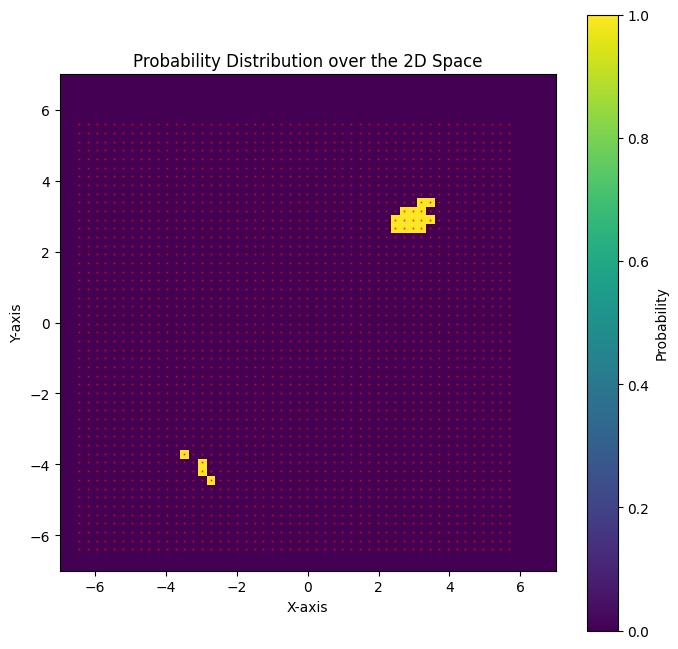

covarage = 50.1
pinaw = 8.12700937687723


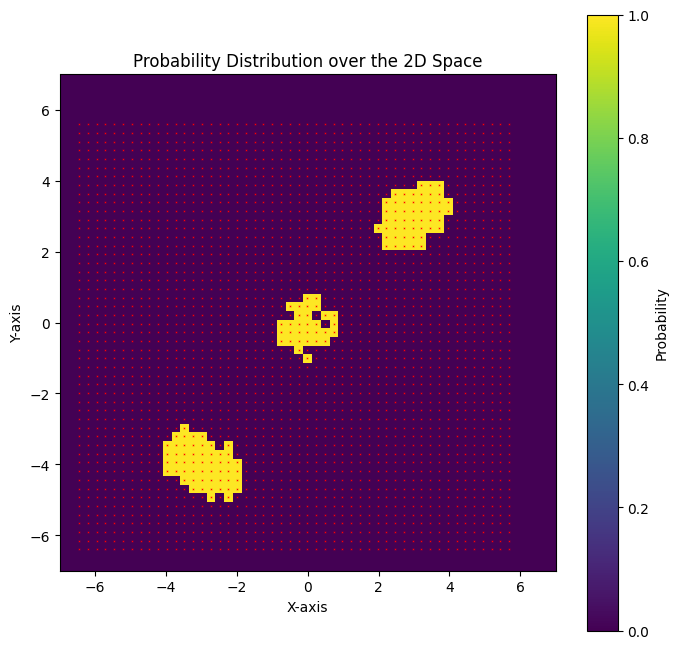

covarage = 90.06666666666666
pinaw = 28.080636876822066


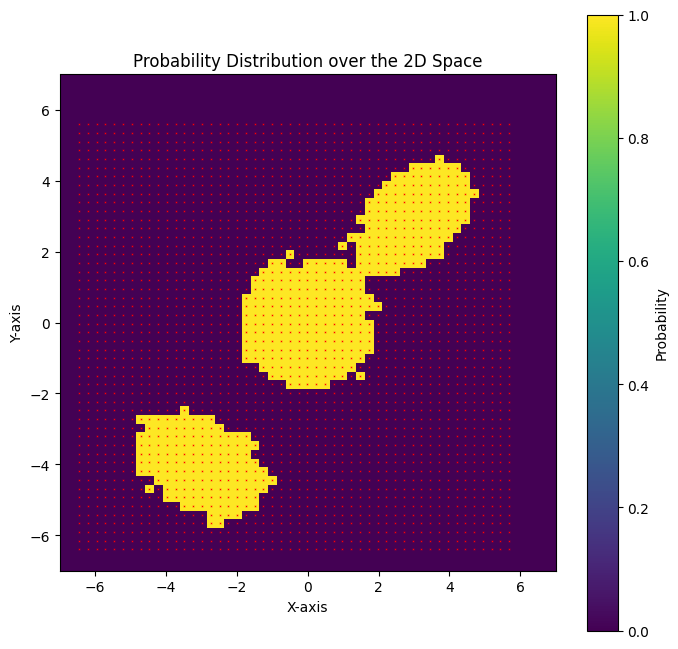

In [15]:

import torch
import numpy as np
import torch.nn.functional as F

# yüzde kaç covarage istiyoz 

for alpha in [0.1,0.5,0.9]:
# alpha = 0.9

    model.eval()
    with torch.no_grad():
        cal_logits = model(cal_x)
        cal_probs = F.softmax(cal_logits, dim=1)
        true_class_probs = [cal_probs[i,cal_y[i]].cpu().item() for i in range(cal_probs.size(0))] 
        true_class_probs = np.array(true_class_probs)
        # sort 
        sorted_true_class_probs = np.sort(true_class_probs)
        p_score = np.quantile(sorted_true_class_probs, 1-alpha)
        
    # Ensure the model is in evaluation mode
    model.eval()



    # Feed the input tensor with value 0
    input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

    # Generate model predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        output_logits = model(input_tensor)

    # Apply softmax to get the probability distribution over the output classes
    # calculate_covarage
    output_probs = torch.softmax(output_logits, dim=1).squeeze(0).cpu().numpy()
    output_probs[output_probs > p_score] = 1
    output_probs[output_probs < p_score] = 0


    number_of_true = 0
    for true_class in test_y:
        number_of_true += output_probs[true_class]
            
    # covarage = number_of_true / all sample number 

    covarage = number_of_true / test_y.size(0)


    output_probs_grid = output_probs.reshape(GLOBAL_BIN_COUNT, GLOBAL_BIN_COUNT)

    # how many of the goes in the area 


    # Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
    x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
    y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

    print(f"covarage = {covarage * 100}") 
    one_square_area = (x_edges - np.roll(x_edges,1))[1] * (y_edges - np.roll(y_edges,1))[1]
    pinaw = (output_probs == 1).sum() * one_square_area
    print(f"pinaw = {pinaw}")

    # Plot the probability distribution over the 2D grid using the bin edges
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

    # Get the colormap and set the color for under 0 values
    cmap = plt.get_cmap('viridis')

    # Set vmin to 0 to make sure the zero probability regions are colored
    im = ax.imshow(output_probs_grid, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), 
                origin='lower', cmap=cmap, vmin=0, vmax=output_probs_grid.max())

    # Set the facecolor of the axes to the color corresponding to the lowest value in the colormap
    ax.set_facecolor(cmap(0))  # This sets the background to the same color as the lowest probability

    # Set the xlim and ylim with no extra background
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)

    # Add the colorbar and labels
    plt.colorbar(im, ax=ax, label='Probability')
    plt.title('Probability Distribution over the 2D Space')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Display proto centers
    xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
    plt.scatter(xx.flatten(), yy.flatten(), marker='x', c='red', s=0.1)
    plt.show()


In [16]:
######### PROTOTYPE 1 ####################33

In [17]:
class UnconditionalProtoClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=GLOBAL_BIN_COUNT*GLOBAL_BIN_COUNT):
        super(UnconditionalProtoClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
        )
        self.fc = nn.Linear(self.hidden_size, self.no_of_classes)
        
    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

In [20]:
from shapely.geometry import Polygon,box
from shapely.ops import unary_union

def calculate_areas(protos):
    # Display prototype centers
    proto_centers = protos.detach().cpu().numpy()
    vor = Voronoi(proto_centers)

    # Define the bounding box within which to clip the Voronoi regions
    bounding_box = box(-7, -7, 7, 7)  # (-7, -7) to (7, 7)
    def polygon_area(vertices):
        vertices = np.array(vertices)
        """Calculate the area of a polygon using the Shoelace theorem."""
        if len(vertices) < 3:  # Not a valid polygon
            return 0.0
        x = vertices[:, 0]
        y = vertices[:, 1]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    regions = []
    region_areas = []

    for i, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        
        # Only include finite Voronoi regions (no infinite vertices, i.e., no '-1' in region)
        if not -1 in region and len(region) > 0:
            polygon = [vor.vertices[j] for j in region]
            voronoi_polygon = Polygon(polygon)
            
            # Clip the Voronoi region to the bounding box
            clipped_polygon = voronoi_polygon.intersection(bounding_box)
            
            # If the clipped polygon is valid, compute its area
            if not clipped_polygon.is_empty:
                regions.append(list(clipped_polygon.exterior.coords))
                area = clipped_polygon.area
                region_areas.append(area)
            else:
                region_areas.append(0.0)  # Empty region
        else:
            region_areas.append(1000.0)  # For infinite regions, you can assign infinity or another placeholder

    region_areas = torch.tensor(region_areas)
    # Check for any problematic area values (NaN or Inf)
    if torch.isnan(region_areas).any() or torch.isinf(region_areas).any():
        print("Warning: NaN or Inf found in region_areas")
        region_areas = torch.clamp(region_areas, min=1e-8,max=20)  # Replace NaNs or Infs

    return region_areas


def distance_based_ce(logits, cdist, protos, temp_logits=1.0, temp_cdist=1.0, epsilon=1e-8):
    # Calculate areas of Voronoi regions and convert them to tensor
    
    areas = torch.tensor(calculate_areas(protos)).to(device)


    # Adjust logits by adding log(areas), ensuring no issues with Inf areas
    adjusted_logits = logits + torch.log(areas).unsqueeze(0).detach()  # Unsqueeze to match batch dimension
    
    # Ensure logits don't have extreme values
    adjusted_logits = adjusted_logits - adjusted_logits.max(dim=1, keepdim=True).values  # Stabilize logits before softmax
    # Compute softmax with stabilized logits
    log_probs = F.softmax(adjusted_logits / temp_logits, dim=1)

    # Apply temperature scaling to cdist for smoother distance normalization
    cdist = cdist / temp_cdist
    cdist = cdist / cdist.sum(dim=1, keepdim=True)

    # Add epsilon to avoid log(0)
    # log_adjusted_probs = torch.log(probs + epsilon)
    
    # Apply cross entropy based on the smoothed L2 distances
    loss = -torch.sum(cdist * log_probs, dim=1)

    # Return the mean loss across the batch
    return loss.mean()
def distance_based_labeling(cdist,logits):
    # take softmax of the cdists
    cdist_probs = F.softmax(-cdist, dim=1)
    
    probs = F.softmax(logits, dim=1)
    
    return F.kl_div(probs, cdist_probs, reduction='batchmean')
def entropy_loss(logits):
    probs = F.softmax(logits, dim=1)
    log_probs = F.log_softmax(logits, dim=1)  # Use log_softmax for numerical stability
    return - torch.sum(probs * log_probs, dim=1).mean()

def repulsion_loss(prototypes, margin=1.0):
    # Calculate the pairwise distances between prototypes
    dists = torch.cdist(prototypes, prototypes, p=2)
    
    # Mask the diagonal (distance between a prototype and itself)
    mask = torch.eye(dists.size(0), device=dists.device).bool()
    dists = dists.masked_fill(mask, float('inf'))
    
    # Apply a margin to ensure prototypes are at least 'margin' apart
    repulsive_term = torch.clamp(margin - dists, min=0)
    return repulsive_term.sum()


# Temp Controls the softness, lower is closer to hard Voronoi
def softmin_grads(prototypes, temperature = 0.1):
    proto_dist_list = torch.cdist(prototypes, prototypes)
    proto_negexp_distances = torch.nn.functional.softmin(proto_dist_list / temperature, dim=-1)
    proto_log_areas = (proto_negexp_distances * torch.eye(len(proto_negexp_distances)).to(device)).sum(dim=0)
    proto_log_soft_areas = torch.log(proto_log_areas)
    return proto_log_soft_areas.sum()



In [24]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
X_bin_centers = moving_average(X_hist[1])
Y_bin_centers = moving_average(Y_hist[1])

xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
cluster_coordinates = np.array(list(zip(xx.flatten(), yy.flatten()))).shape

initial_prototypes = np.stack([xx.flatten(), yy.flatten()], axis=1)

# CROSS ENTROPY LOSS
protos = nn.Parameter(torch.Tensor(initial_prototypes).to(device) ,requires_grad=True)
# protos = nn.Parameter(torch.Tensor(torch.randn((500,2))* 5).to(device) ,requires_grad=True)
# CROSS ENTROPY LOSS

Y = torch.from_numpy(data_samples).to(torch.float32).to(device)
X = torch.zeros(Y.size(0)).reshape(-1,1).float().to(device)
# split the data
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=1)
test_x, cal_x, test_y, cal_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1)


model = UnconditionalProtoClassifier(no_of_classes = len(protos)).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = distance_based_ce

optimizer = torch.optim.Adam(params=list(model.parameters())+ [protos], lr=0.05)


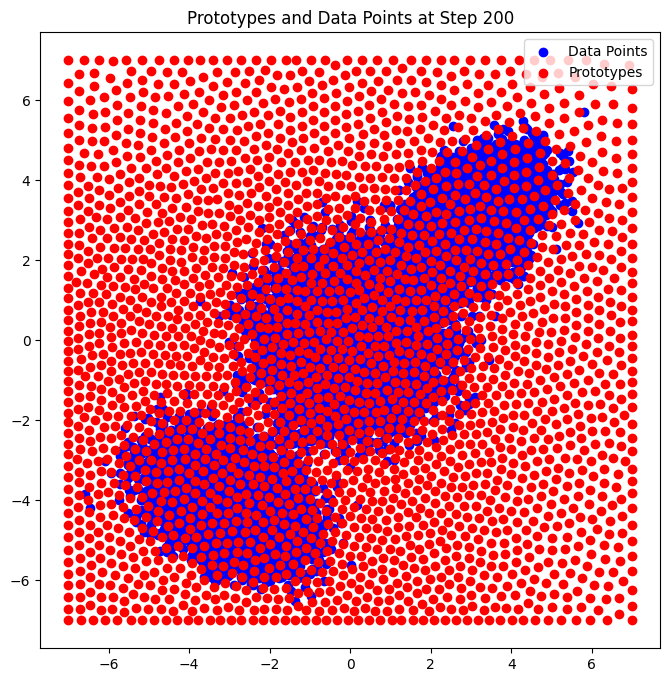

epoch 200, loss=6.083, CE_Loss: 6.082637310028076, MinDist_Loss: 0.10207682847976685,rep_loss: 0.0


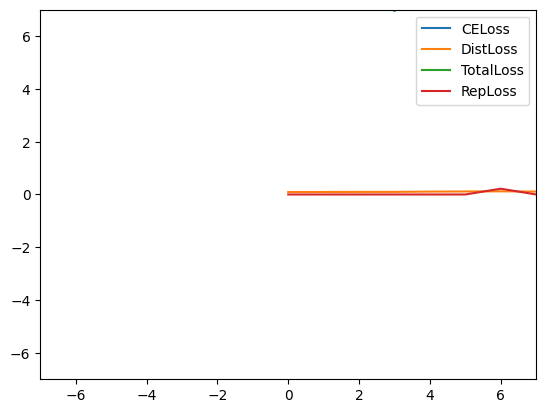

In [25]:
ce_losses = []
mindist_losses = []
repulsion_losses = []
torch.manual_seed(0)
losses = []
for step in range(200):
    # Visualization
    with torch.no_grad():
        protos.clamp_(-7, 7)
    if (step==0) or ((step+1) % 10 == 0):
        sleep(0.1)
        clear_output(wait=True)
        # Visualize protos
        plt.figure(figsize=(8, 8))
        plt.scatter(train_y.cpu().numpy()[:, 0], train_y.cpu().numpy()[:, 1], c='blue', label='Data Points')
        plt.scatter(protos.detach().cpu().numpy()[:, 0], protos.detach().cpu().numpy()[:, 1], c='red', label='Prototypes')
        plt.title(f'Prototypes and Data Points at Step {step+1}')
        plt.legend()
        plt.show()
    # Clear unused protos
    # if step == 50:
    # if step == 100:
    # if (step!=0) and ((step+1) % 50 == 0):
    #     with torch.no_grad():
    #         logits = model(train_x)
    #         cdist_list = torch.cdist(train_y, protos, p=2)
    #         mindist, pos = torch.min(cdist_list, dim=1)
    #         prototype_usage = torch.bincount(pos, minlength=protos.size(0)).detach()
    #         active_prototypes = torch.where(prototype_usage > 0)[0]
    #         model.fc.weight = torch.nn.parameter.Parameter(torch.index_select(model.fc.weight, dim=0, index=active_prototypes), requires_grad=True)
    #         model.fc.bias = torch.nn.parameter.Parameter(torch.index_select(model.fc.bias, dim=0, index=active_prototypes), requires_grad=True)
    #         protos = torch.nn.parameter.Parameter(torch.index_select(protos, dim=0, index=active_prototypes), requires_grad=True)
    #     optimizer = torch.optim.Adam(params=list(model.parameters())+ [protos], lr=0.05)

    model.train()
    optimizer.zero_grad()
    logits = model(train_x)
    
    cdist_list = torch.cdist(train_y, protos, p=2)
    mindist, pos = torch.min(cdist_list, dim=1)
    
    lambda_fact = 1
    
    areas = calculate_areas(protos)
    adjusted_logits = logits + torch.log(areas).unsqueeze(0).detach().to(device) + softmin_grads(protos) - softmin_grads(protos).detach()
    
    ce_loss = criterion(adjusted_logits, pos)
    mindist_loss = lambda_fact * torch.mean(mindist)
    
    # ce_loss = criterion(logits, pos)
    # protos2protos_dist = 0.1 * (-torch.cdist(protos, protos, p=2).topk(k=2, dim=1, largest=False).values.mean())
    # ce_loss = distance_based_ce(logits, cdist_list,protos,temp_logits=1, temp_cdist=1)
    
    rep_loss = 0.5 * repulsion_loss(protos,0.02)
    loss = ce_loss #+ mindist_loss + rep_loss #+ protos2protos_dist
    
    ce_losses.append(ce_loss.data.item())
    mindist_losses.append(mindist_loss.data.item())
    repulsion_losses.append(rep_loss.data.item())
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    loss.backward()
    # clip the protos gradient
    torch.nn.utils.clip_grad_norm_(protos, 0.1)
    optimizer.step()

    if (step==0) or ((step+1) % 10 == 0):
        print(f'epoch {step+1}, loss={loss.data.item():.4}, CE_Loss: {ce_loss.data.item()}, MinDist_Loss: {mindist_loss.data.item()},rep_loss: {rep_loss.data.item()}')

plt.xlim(-7,7)
plt.ylim(-7,7)

plt.plot(ce_losses, label='CELoss')
plt.plot(mindist_losses, label='DistLoss')
plt.plot(losses, label='TotalLoss')
plt.plot(repulsion_losses, label='RepLoss')
plt.legend()

Coverage of the data by the top Voronoi regions: 10.30%
PINAW Score: 1.09584


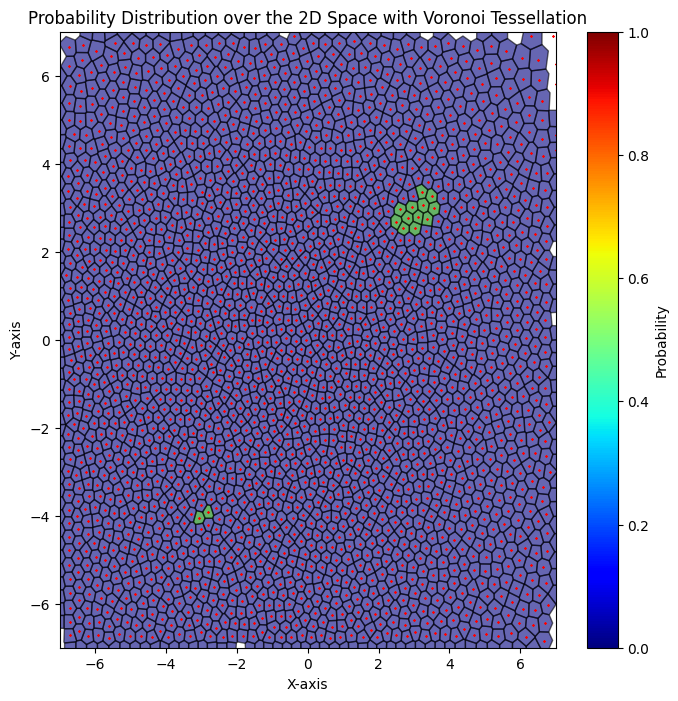

Coverage of the data by the top Voronoi regions: 49.20%
PINAW Score: 8.12536


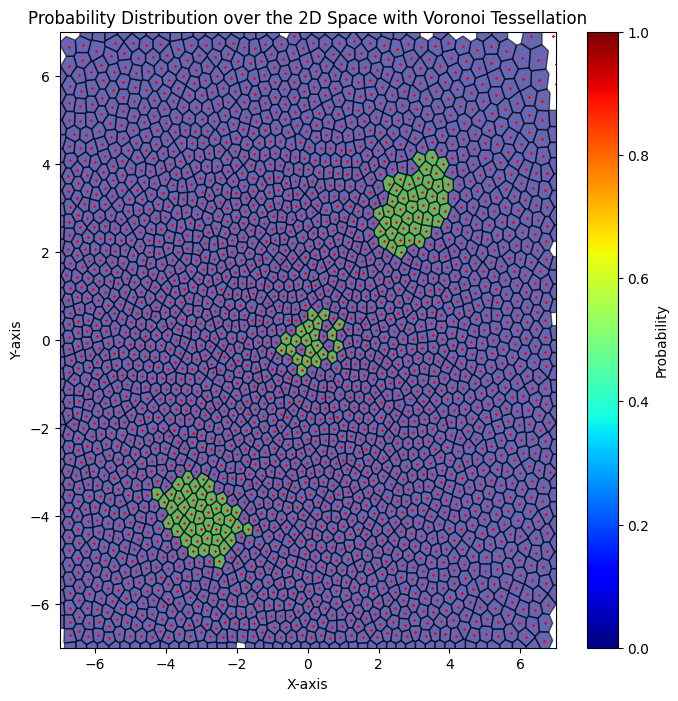

Coverage of the data by the top Voronoi regions: 88.43%
PINAW Score: 27.98714


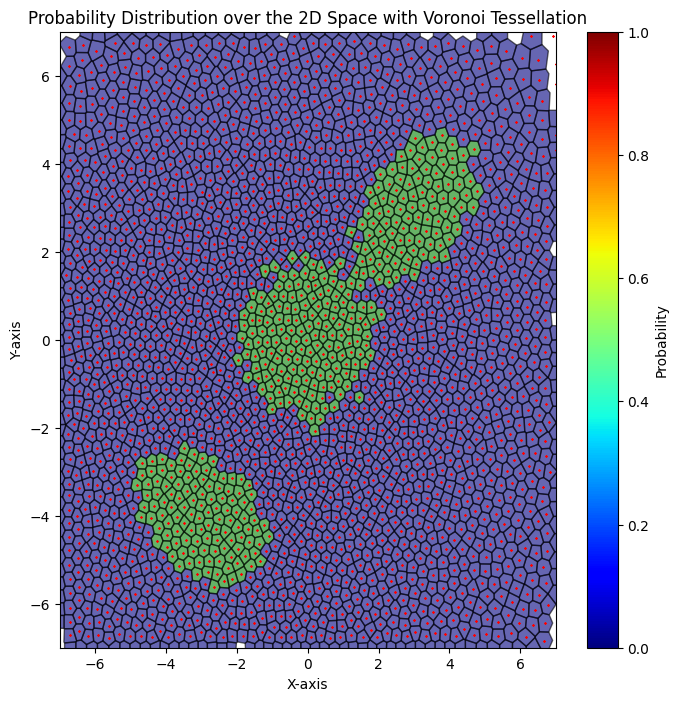

In [26]:
# Ensure the model is in evaluation mode
for alpha in [0.1,0.5,0.9]:
    model.eval()

    # Feed the input tensor with value 0
    input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

    # Generate model predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        output_logits = model(input_tensor)

    # Apply softmax to get the probability distribution over the output classes
    # output_probs = torch.softmax(output_logits, dim=1).cpu().numpy()


    # output_probs_flat = output_probs.flatten()

    # Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
    x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
    y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

    # Flatten the output probabilities to match with the prototypes
    flat_probs = output_probs.flatten()

    # Display prototype centers
    proto_centers = protos.detach().cpu().numpy()

    # Perform Voronoi tessellation
    vor = Voronoi(proto_centers)

    def polygon_area(vertices):
        vertices = np.array(vertices)
        """Calculate the area of a polygon using the Shoelace theorem."""
        x = vertices[:, 0]
        y = vertices[:, 1]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    # Plot the probability distribution over the 2D grid using the bin edges
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

    highlight_color = 'green'  # Color for top_indices regions

    # Create the colormap for other regions
    cmap = plt.get_cmap('jet')
    norm = plt.Normalize(vmin=flat_probs.min(), vmax=flat_probs.max())

    regions = []
    region_areas = []

    # Loop through each prototype and its corresponding Voronoi region
    for i, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        
        # Only include finite Voronoi regions (no infinite vertices, i.e., no '-1' in region)
        if not -1 in region and len(region) > 0:
            polygon = [vor.vertices[j] for j in region]
            regions.append(polygon)
            area = polygon_area(polygon)
            region_areas.append(area)
        else:
            region_areas.append(float('inf'))  # For infinite regions, you can assign infinity or another placeholder
    
    region_areas = calculate_areas(protos).to(device)
    adjusted_probs = output_logits +  torch.log(region_areas)
    adjusted_probs = torch.softmax(adjusted_probs, dim=1).cpu().numpy().flatten()

    sorted_indices = np.argsort(output_logits.cpu().numpy().flatten())[::-1] # sort according to the log density sıralamayı densitye göre aç 
    
    sorted_output_probs = adjusted_probs[sorted_indices]
    sorted_output_log_densities = output_logits.cpu().numpy().flatten()[sorted_indices] # get the log density 

    import torch
    import numpy as np
    import torch.nn.functional as F

    # yüzde kaç covarage istiyoz 


    model.eval()
    with torch.no_grad():
        cal_logits = model(cal_x)
        # cal_probs = F.softmax(cal_logits, dim=1)
    
        # adjusted_probs = cal_probs.cpu() / torch.tensor(region_areas).unsqueeze(0)
        # adjusted_probs = adjusted_probs/adjusted_probs.sum(keepdim=True, dim=1)
        
        adjusted_probs = cal_logits + torch.log(region_areas)
        adjusted_probs = torch.softmax(adjusted_probs, dim=1)
        
        cdist_list = torch.cdist(cal_y, protos, p=2)
        mindist, pos = torch.min(cdist_list, dim=1)
        
        true_class_probs = [adjusted_probs[i,pos[i]].cpu().item() for i in range(adjusted_probs.size(0))] 
        true_class_probs = np.array(true_class_probs)
        # sort 
        sorted_true_class_probs = np.sort(true_class_probs)
        p_score = np.quantile(sorted_true_class_probs, 1-alpha)
    # threshold_index = np.where(cumulative_sum >= p_score)[0][0]
    
    threshold_index = np.where(sorted_output_probs >= p_score)
    top_indices = sorted_indices[threshold_index]


    from scipy.spatial import distance
    # Move test_y to CPU and convert to numpy if it's a PyTorch tensor
    if isinstance(test_y, torch.Tensor):
        test_y = test_y.cpu().numpy()

    assigned_regions = []
    for point in test_y:  # Assuming test_y is a 2D array or list of points
        distances = distance.cdist([point], proto_centers)  # Calculate distance to all prototype centers
        nearest_proto_index = np.argmin(distances)
        assigned_regions.append(nearest_proto_index)

    # The rest of the code remains the same
    top_region_data_count = 0
    total_data_count = len(test_y)

    for assigned_region in assigned_regions:
        if assigned_region in top_indices:
            top_region_data_count += 1

    coverage_percentage = (top_region_data_count / total_data_count) * 100

    print(f"Coverage of the data by the top Voronoi regions: {coverage_percentage:.2f}%")
    pinaw_score = np.array(region_areas.cpu())[top_indices].sum() 
    print(f"PINAW Score: {pinaw_score:.5f}")

    colors = []
    for i, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if not -1 in region and len(region) > 0:
            polygon = [vor.vertices[j] for j in region]
            # colors.append(cmap(norm(adjusted_probs[i])))
            if i in top_indices:
                colors.append(highlight_color)  # Use the highlight color for top regions
            else:
                colors.append(cmap(0))


    # Create a PolyCollection for Voronoi regions
    voronoi_region_collection = PolyCollection(regions, facecolors=colors, edgecolors='k', alpha=0.6)
    ax.add_collection(voronoi_region_collection)

    # Plot prototype centers
    ax.scatter(proto_centers[:, 0], proto_centers[:, 1], marker='x', c='red', s=1)

    # Set the axis limits and labels
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.title('Probability Distribution over the 2D Space with Voronoi Tessellation')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Probability')

    plt.show()


In [21]:

proto_centers = protos.detach().cpu().numpy()
vor = Voronoi(proto_centers)

def polygon_area(vertices):
    vertices = np.array(vertices)
    """Calculate the area of a polygon using the Shoelace theorem."""
    x = vertices[:, 0]
    y = vertices[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

regions = []
region_areas = []

# Loop through each prototype and its corresponding Voronoi region
for i, region_index in enumerate(vor.point_region):
    region = vor.regions[region_index]
    
    # Only include finite Voronoi regions (no infinite vertices, i.e., no '-1' in region)
    
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[j] for j in region]
        regions.append(polygon)
        area = polygon_area(polygon)
        # Prevent zero or very small areas
        # region_areas.append(max(area, 1e-6))  # Avoid areas smaller than 1e-6
        region_areas.append(area)
    else:
        region_areas.append(float('inf'))  # For infinite regions, assign infinity or another placeholder

region_areas = torch.tensor(region_areas)

In [22]:
(region_areas == float('inf')).sum()

tensor(196)

In [23]:
region_areas[region_areas != float('inf')].argmax()

tensor(2)

In [24]:
region_areas.sum() - 48*20

tensor(inf, dtype=torch.float64)

In [25]:
output_density = torch.exp(output_logits).cpu().numpy().flatten()
output_density.mean(), output_density.std(), output_density.max(), output_density.min()

(6.109665, 14.680322, 111.31821, 0.0022044973)

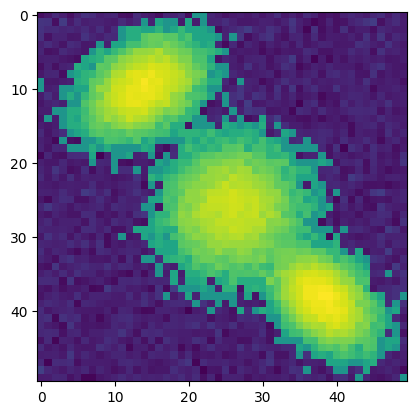

In [26]:
plt.imshow(output_logits.detach().cpu().flatten().reshape(GLOBAL_BIN_COUNT,GLOBAL_BIN_COUNT))

In [27]:
plt.imshow(polygon_area.detach().cpu().flatten().reshape(50,50))

AttributeError: 'function' object has no attribute 'detach'

In [28]:
output_logits.shape

torch.Size([1, 2500])

In [29]:
np.mean(region_areas[region_areas != float('inf')])

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [30]:
region_areas = np.array(region_areas)
region_areas = region_areas[region_areas != float('inf')]
np.mean(region_areas),np.std(region_areas),np.min(region_areas),np.max(region_areas)

(0.06064932482753961,
 1.9624427977568068e-08,
 0.06064927346497484,
 0.06064936136681354)

In [31]:
proto_centers = np.array(proto_centers)
proto_centers = proto_centers[proto_centers != float('inf')]
np.mean(proto_centers),np.std(proto_centers),np.min(proto_centers),np.max(proto_centers)

(-0.39307266, 3.5540361, -6.4538083, 5.684781)

In [32]:
probabs = np.array(adjusted_probs)
probabs = probabs[probabs != float('inf')]
np.mean(probabs),np.std(probabs),np.min(probabs),np.max(probabs)

NameError: name 'adjusted_probs' is not defined

In [33]:
pinaw_score = np.array(region_areas)[top_indices].sum() 
print(pinaw_score)

IndexError: index 28542 is out of bounds for axis 0 with size 2304

In [34]:
adjusted_probs.sum()

NameError: name 'adjusted_probs' is not defined

In [44]:
adjusted_probs.argsort()

NameError: name 'adjusted_probs' is not defined

In [45]:
cal_probs = np.array(cal_probs.detach().cpu())
cal_probs = cal_probs[cal_probs != float('inf')]
np.mean(cal_probs),np.std(cal_probs),np.min(cal_probs),np.max(cal_probs)


(0.00039999993, 0.00096115615, 1.16140384e-07, 0.0072883326)

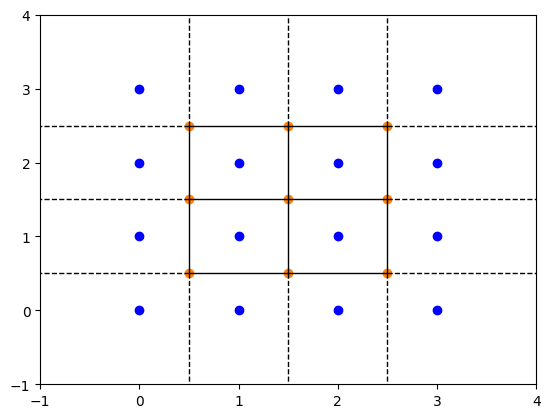

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Generate points in the grid between (0,0) and (3,3)
points = np.array([[x, y] for x in range(4) for y in range(4)])

# Calculate the Voronoi diagram
vor = Voronoi(points)

# Plot the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)

# Plot the original points
ax.plot(points[:, 0], points[:, 1], 'bo')  # Plot the points

# Set axis limits
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 4)

plt.show()

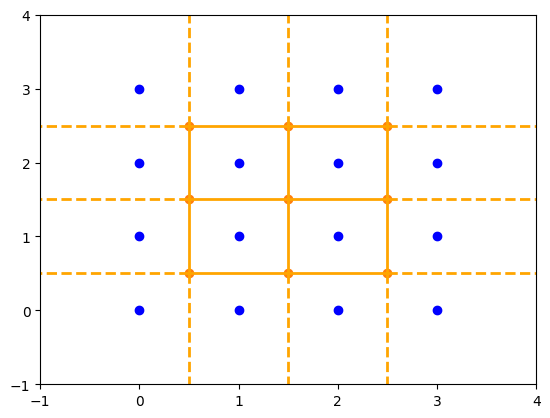

(array([[0.5, 2.5],
        [0.5, 1.5],
        [0.5, 0.5],
        [2.5, 0.5],
        [1.5, 0.5],
        [1.5, 1.5],
        [1.5, 2.5],
        [2.5, 1.5],
        [2.5, 2.5]]),
 [[],
  [-1, 0],
  [2, -1, 1],
  [-1, 1, 0],
  [4, -1, 3],
  [4, 2, -1],
  [2, -1],
  [3, -1],
  [8, 6, 5, 7],
  [4, 3, 7, 5],
  [5, 6, 0, 1],
  [8, -1, 6],
  [7, 8, -1],
  [4, 2, 1, 5],
  [-1, 6, 0],
  [7, -1, 3],
  [8, -1]])

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Generate points in the grid between (0,0) and (3,3)
points = np.array([[x, y] for x in range(4) for y in range(4)])

# Calculate the Voronoi diagram
vor = Voronoi(points)

# Plot the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='orange', line_width=2, point_size=10)

# Plot the original points
ax.plot(points[:, 0], points[:, 1], 'bo')  # Plot the points

# Set axis limits
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 4)

# Display Voronoi points and region vertices
voronoi_points = vor.vertices
regions = vor.regions

plt.show()

voronoi_points, regions  # Displaying the Voronoi vertices and region info

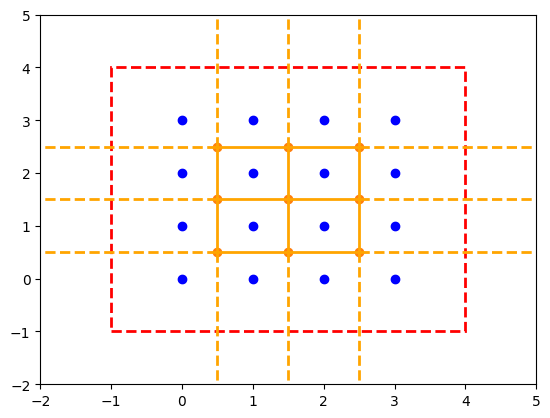

In [48]:
from scipy.spatial import voronoi_plot_2d
from matplotlib.patches import Polygon

# Define the bounding box as ((-1, -1), (4, -1), (4, 4), (-1, 4))
bounding_box = np.array([[-1, -1], [4, -1], [4, 4], [-1, 4]])

# Plot the Voronoi diagram with bounding box
fig, ax = plt.subplots()

# Plot the Voronoi diagram with vertices
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='orange', line_width=2, point_size=10)

# Plot the original points
ax.plot(points[:, 0], points[:, 1], 'bo')

# Add the bounding box as a polygon
bounding_polygon = Polygon(bounding_box, closed=True, fill=None, edgecolor='r', linewidth=2, linestyle='--')
ax.add_patch(bounding_polygon)

# Set the axis limits
ax.set_xlim(-2, 5)
ax.set_ylim(-2, 5)

plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.ops import clip_by_rect

# Define the bounding box as ((-1, -1), (4, -1), (4, 4), (-1, 4))
bounding_box = np.array([[-1, -1], [4, -1], [4, 4], [-1, 4]])

# Generate points in the grid between (0,0) and (3,3)
points = np.array([[x, y] for x in range(4) for y in range(4)])

# Calculate the Voronoi diagram
vor = Voronoi(points)

# Function to clip a Voronoi region with a bounding box and calculate the area
def calculate_clipped_area(region, vertices, bounding_box):
    if -1 in region:  # Skip infinite regions
        return 0
    
    polygon_points = vertices[region]
    voronoi_polygon = ShapelyPolygon(polygon_points)
    
    # Create a bounding box polygon
    bounding_polygon = ShapelyPolygon(bounding_box)
    
    # Clip the Voronoi polygon by the bounding box
    clipped_polygon = voronoi_polygon.intersection(bounding_polygon)
    
    # Return the area of the clipped polygon
    return clipped_polygon.area

# Plot the Voronoi diagram with bounding box
fig, ax = plt.subplots()

# Plot the Voronoi diagram with vertices
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='orange', line_width=2, point_size=10)

# Plot the original points
ax.plot(points[:, 0], points[:, 1], 'bo')

# Add the bounding box as a polygon
bounding_polygon = Polygon(bounding_box, closed=True, fill=None, edgecolor='r', linewidth=2, linestyle='--')
ax.add_patch(bounding_polygon)

# Store the areas of the clipped Voronoi regions
clipped_areas = []

# Iterate over each Voronoi region and calculate the clipped area
for region_idx, region in enumerate(vor.regions):
    if not region or -1 in region:
        continue  # Skip infinite or empty regions
    
    # Get the clipped polygon area for the region
    area = calculate_clipped_area(region, vor.vertices, bounding_box)
    clipped_areas.append(area)
    
    # Also, display the clipped regions on the plot
    clipped_polygon = calculate_clipped_area(region, vor.vertices, bounding_box)
    if clipped_polygon > 0:
        polygon_points = vor.vertices[region]
        patch = Polygon(polygon_points, closed=True, fill=True, edgecolor='blue', alpha=0.4)
        ax.add_patch(patch)

# Set the axis limits
ax.set_xlim(-2, 5)
ax.set_ylim(-2, 5)

plt.show()

# Display the clipped areas
import pandas as pd
areas_df = pd.DataFrame(clipped_areas, columns=['Clipped Area'])
# import ace_tools as tools; tools.display_dataframe_to_user(name="Clipped Voronoi Areas", dataframe=areas_df)

ModuleNotFoundError: No module named 'shapely'

In [102]:
clipped_areas

[1.0, 1.0, 1.0, 1.0]